In [1]:
import cv2
import matplotlib.pyplot as plt


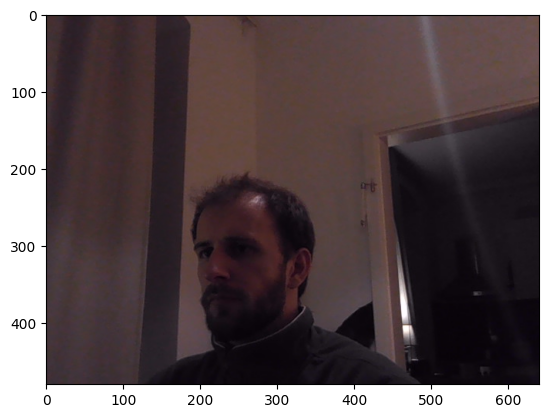

In [2]:
# Second cell - capture image
cap = cv2.VideoCapture(0)
cv2.waitKey(2000)
ret, frame = cap.read()
cap.release()

frame_rgb = None

if ret:
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.show()
else:
    print("Failed to capture image")

c:\dev\TU\ODS\ods-playground\vendor\Depth-Anything-V2
(480, 640)


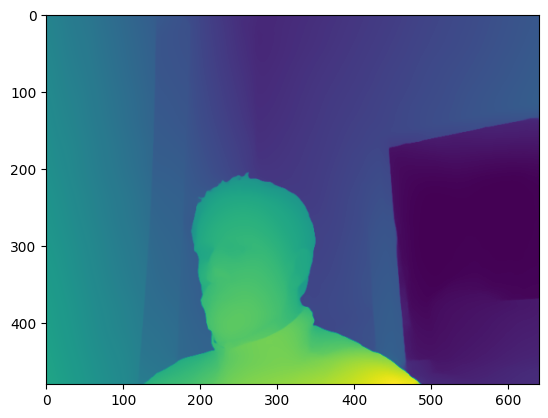

In [3]:
#sys.path.append('../pipeline/components/pc_generator')
from pipeline.components.pc_generator.DepthEstimator import DepthEstimator

depth_estimator = DepthEstimator()
depth = depth_estimator.predict(frame_rgb)
print(depth.shape)
plt.imshow(depth)